In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib_inline.backend_inline as backend_inline
from torchsummary import summary

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###
# # Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [2]:
# Create the Dataset
nPerClass = 1000  # Number of samples per class
imgSize = 91  # Image size (91x91)

x = np.linspace(-4, 4, imgSize)
# print("x.shape:", x.shape)
X, Y = np.meshgrid(x, x)
# print("X.shape:", X.shape, "Y.shape:", Y.shape)
# print(Y)
# The Two widths (Arbetary Units)
widths = [1.8, 2.4]

# Initialize tensors containing images and labels
images = torch.zeros(2 * nPerClass, 1, imgSize, imgSize)  # Zeros in the right shape
labels = torch.zeros(2 * nPerClass)  # Zeros in the right shape

# Generate the images

for i in range(2 * nPerClass):
    # Create the gaussian with random center
    ro = 2 * np.random.randn(2)  # ro = randome offset
    G = np.exp(-((X - ro[0]) ** 2 + (Y - ro[1]) ** 2) / (2 * widths[i % 2] ** 2))

    # Add the noise
    G = G + np.random.randn(imgSize, imgSize) / 5

    # Add to tensor
    images[i, :, :, :] = torch.tensor(G).view(1, imgSize, imgSize)
    labels[i] = i % 2

labels = labels.reshape(-1, 1)  # Reshape labels to be a column vector
print("images.shape:", images.shape, "labels.shape:", labels.shape)

images.shape: torch.Size([2000, 1, 91, 91]) labels.shape: torch.Size([2000, 1])


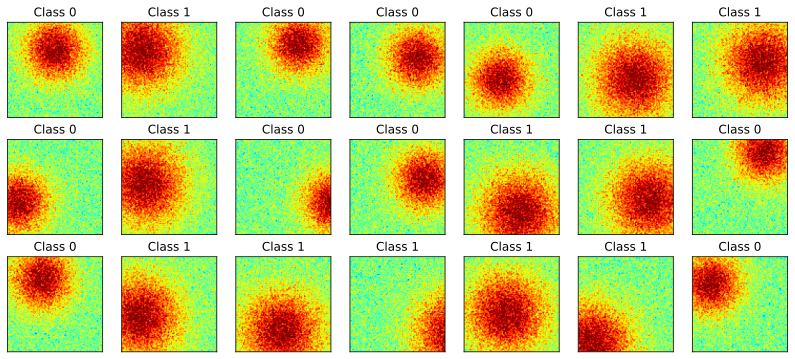

In [3]:
# Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(14, 6))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(2 * nPerClass)
    G = np.squeeze(images[whichpic, :, :])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet")
    ax.set_title("Class %s" % int(labels[whichpic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [4]:
# Create train/test groups using Dataloaders
train_data, test_data, train_labels, test_labels = train_test_split(
    images, labels, train_size=0.8
)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Create DataLoaders
train_loader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device=device),
)
test_loader = DataLoader(
    test_data,
    batch_size=test_data.tensors[0].shape[0],
    generator=torch.Generator(device=device),
)

# Print the shapes of the datasets
print(
    "Train Data Shape:",
    train_data.tensors[0].shape,
    "\nTrain Labels Shape:",
    train_data.tensors[1].shape,
    "\n============================================",
)
print(
    "Test Data Shape:",
    test_data.tensors[0].shape,
    "\nTest Labels Shape:",
    test_data.tensors[1].shape,
)

Train Data Shape: torch.Size([1600, 1, 91, 91]) 
Train Labels Shape: torch.Size([1600, 1]) 
Test Data Shape: torch.Size([400, 1, 91, 91]) 
Test Labels Shape: torch.Size([400, 1])


In [12]:
# Create CNN Model
def create_cnn_model():
    class gausnet(nn.Module):

        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(
                1, 6, 3, padding=1
            )  # Input channels = 1, Output channels = 6, Kernel size = 3
            self.conv2 = nn.Conv2d(
                6, 4, 3, padding=1
            )  # Input channels = 6, Output channels = 4, Kernel size = 3
            self.fc1 = nn.Linear(
                4 * 22 * 22, 50
            )  # Input features = 4 * 22 * 22 = 1936, Output features = 50
            self.out = nn.Linear(50, 1)  # Input features = 50, Output features = 1

        def forward(self, x):
            conv1_act = F.relu(self.conv1(x))
            x = F.max_pool2d(conv1_act, (2, 2)) # Apply first conv layer and ReLU, then max pool
            conv2_act = F.relu(self.conv2(x))
            x = F.max_pool2d(conv2_act, (2, 2))
            # Apply second conv layer and ReLU, then max pool

            x = x.reshape(x.shape[0], -1)  # Flatten the tensor
            x = F.relu(self.fc1(x))
            x = self.out(x)  # Apply output layer
            return x, conv1_act, conv2_act  # Return the output logits

    # Create the model instance
    net = gausnet()

    # Loss Function
    lossFun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

    return net, lossFun, optimizer

In [13]:
# test the model with one batch
net, lossfun, optimizer = create_cnn_model()

# test that the model runs and can compute a loss
X, y = next(iter(train_loader))
yHat, conv1_act, conv2_act= net(X)
loss = lossfun(yHat, y)

# check sizes of outputs
print("Predicted category:")
print(yHat.shape)
print("\nFeature map after conv1")
print(conv1_act.shape)
print("\nFeature map after conv2")
print(conv2_act.shape)

Predicted category:
torch.Size([32, 1])

Feature map after conv1
torch.Size([32, 6, 91, 91])

Feature map after conv2
torch.Size([32, 4, 45, 45])


In [14]:
# count the total number of parameters in the model
summary(net, (1, imgSize, imgSize))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 91, 91]           60
├─Conv2d: 1-2                            [-1, 4, 45, 45]           220
├─Linear: 1-3                            [-1, 50]                  96,850
├─Linear: 1-4                            [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 0.98
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 91, 91]           60
├─Conv2d: 1-2                            [-1, 4, 45, 45]           220
├─Linear: 1-3                            [-1, 50]                  96,850
├─Linear: 1-4                            [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 0.98
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84

In [17]:
# Function to train the model


def train_the_model(train_loader, test_loader, epochs=10):
    # Create the model
    net, lossFun, optimizer = create_cnn_model()

    # Initialize lists to store losses
    trainLoss = torch.zeros(epochs)
    testLoss = torch.zeros(epochs)
    trainAcc = torch.zeros(epochs)
    testAcc = torch.zeros(epochs)

    # Training loop
    for epoch in range(epochs):
        # print(f"Epoch {epoch + 1}/{epochs}")
        net.train()

        # Batch training
        batchLoss = []
        batchAcc = []
        for X, y in train_loader:
            # Forward pass
            yHat = net(X)[0]
            loss = lossFun(yHat, y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Batch Loss and Accuracy
            batchLoss.append(loss.cpu().item())
            batchAcc.append(torch.mean((((yHat > 0) == y).float())).cpu().item())
        # End of batch training
        trainLoss[epoch] = np.mean(batchLoss)
        trainAcc[epoch] = 100 * np.mean(batchAcc)

        # Test Loss and Accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)[0]
            loss = lossFun(yHat, y)
        testLoss[epoch] = loss.cpu().item()
        testAcc[epoch] = 100 * torch.mean(((yHat > 0) == y).float()).cpu().item()
        # End of epoch

    # Function output
    return net, trainLoss, testLoss, trainAcc, testAcc

In [22]:
net, trainLoss, testLoss, trainAcc, testAcc = train_the_model(train_loader, test_loader, epochs=20)

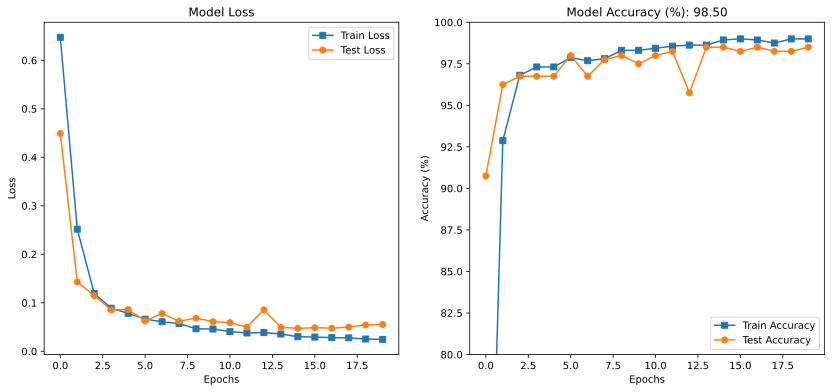

In [23]:
# Visualize the training and testing loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(trainLoss.cpu(), "s-", label="Train Loss")
axs[0].plot(testLoss.cpu(), "o-", label="Test Loss")
axs[0].set_title("Model Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

axs[1].plot(trainAcc.cpu(), "s-", label="Train Accuracy")
axs[1].plot(testAcc.cpu(), "o-", label="Test Accuracy")
axs[1].set_title(f"Model Accuracy (%): {testAcc[-1].cpu().item():.2f}")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy (%)")
axs[1].set_ylim(80, 100)
axs[0].legend()
axs[1].legend()

plt.show()

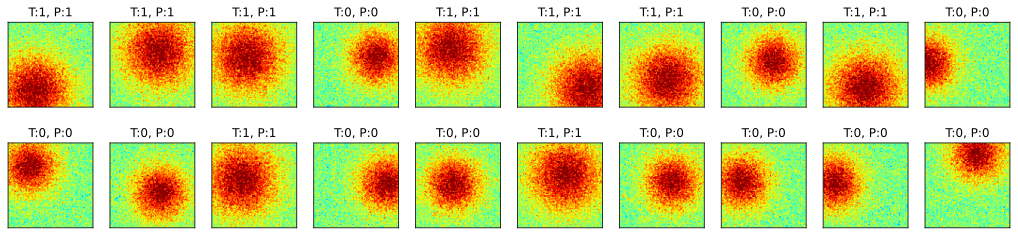

In [28]:
# Visualize some images
X, y = next(iter(test_loader))
yHat, conv1_act, conv2_act = net(X)

fig, axs = plt.subplots(2, 10, figsize=(18, 4))

for i, ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, 0, :, :]).cpu().detach()
    ax.imshow(G, vmin=-1, vmax=1, cmap="jet")
    t = (int(y[i].item()), int(yHat[i].cpu().item() > 0))
    ax.set_title("T:%s, P:%s" % t)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

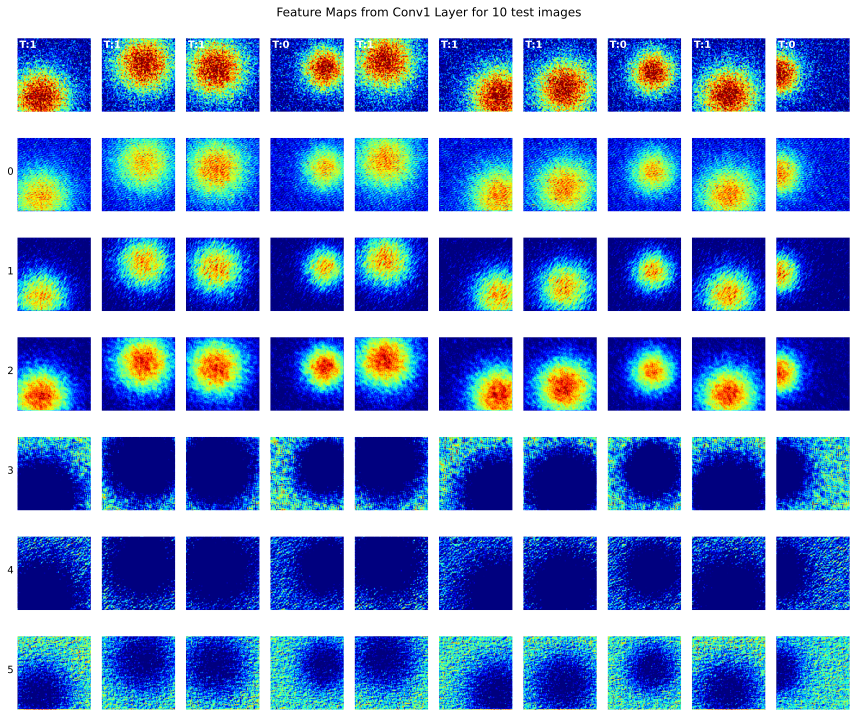

In [35]:
# Feature maps from the conv1 layer
fig, axs = plt.subplots(7, 10, figsize=(12, 10))

for pic in range(10):

    # Show the original image
    img = X[pic, 0, :, :].cpu().detach()
    axs[0, pic].imshow(img, cmap="jet", vmin=0, vmax=1)
    axs[0, pic].axis("off")
    axs[0, pic].text(
        2,
        2,
        "T:%s" % int(y[pic].item()),
        ha="left",
        va="top",
        color="w",
        fontweight="bold",
    )

    for feature in range(6):
        # Show the feature map for this image
        img = conv1_act[pic, feature, :, :].cpu().detach()
        axs[feature+1, pic].imshow(img, cmap="jet", vmin=0, vmax=torch.max(img)*0.9)
        axs[feature+1, pic].axis("off")
        axs[feature+1, pic].text(-5,45,feature,ha="right") if pic == 0 else None

plt.tight_layout()
plt.suptitle("Feature Maps from Conv1 Layer for 10 test images", x = 0.5, y = 1.01)
plt.show()